In [9]:

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')
 
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
 
df = pd.read_csv("./data/finance/febaban1.csv",parse_dates=[0],index_col=0)
df.head()

,Abandono
Fecha,
2019-02-01,164
2019-02-02,63
2019-02-03,239
2019-02-04,2
2019-02-05,502


In [10]:

print(df.index.min())
print(df.index.max())


2019-02-01 00:00:00
2020-02-15 00:00:00


In [11]:
PASOS=7
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
values = values.astype('datetime64')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.565684,-0.836461,-0.364611,-1.000000,0.340483,-0.466488,-0.522788,-0.710456
8,-0.836461,-0.364611,-1.000000,0.340483,-0.466488,-0.522788,-0.710456,-0.986595
9,-0.364611,-1.000000,0.340483,-0.466488,-0.522788,-0.710456,-0.986595,-0.983914
10,-1.000000,0.340483,-0.466488,-0.522788,-0.710456,-0.986595,-0.983914,-0.646113
11,0.340483,-0.466488,-0.522788,-0.710456,-0.986595,-0.983914,-0.646113,-0.930295


In [12]:

# split into train and test sets
values = reframed.values
n_train_days = 28+1 - (3+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(19, 1, 7) (19,) (17, 1, 7) (17,)


In [13]:

def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [18]:

EPOCHS=7
model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1, 7)              56        
_________________________________________________________________
flatten_4 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Train on 19 samples, validate on 17 samples
Epoch 1/7
19/19 [==============================] - ETA: 0s - loss: 0.4632 - mse: 0.394 - 1s 36ms/step - loss: 0.6244 - mse: 0.5547 - val_loss: 0.4398 - val_mse: 0.2706
Epoch 2/7
19/19 [==============================] - 0s 1ms/step - loss: 0.5974 - mse: 0.5296 - val_loss: 0.4042 - val_mse: 0.2340
Epoch 3/7
19/19 [==============================

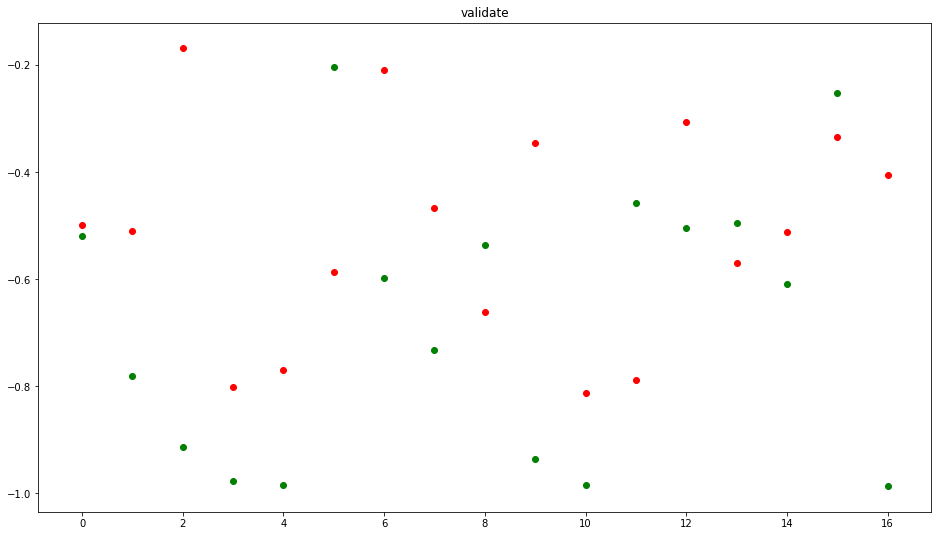

In [19]:
results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

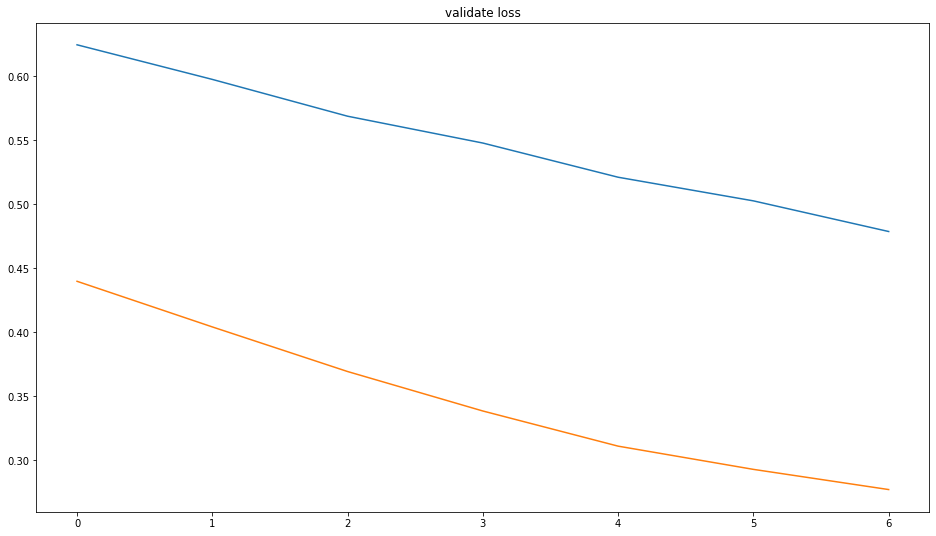

In [20]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

In [21]:
df.head()

,Abandono
Fecha,
2019-02-01,164
2019-02-02,63
2019-02-03,239
2019-02-04,2
2019-02-05,502


In [22]:
ultimosDias = df['2019-02-15':'2019-02-28']
ultimosDias

,Abandono
Fecha,
2019-02-15,93
2019-02-16,18
2019-02-17,6
2019-02-18,748
2019-02-19,192
2019-02-20,63
2019-02-21,127
2019-02-22,90
2019-02-23,7


In [23]:
values = ultimosDias.values
values = values.astype('int64')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.765499,-0.967655,-1.000000,1.000000,-0.498652,-0.846361,-0.673854
8,-0.967655,-1.000000,1.000000,-0.498652,-0.846361,-0.673854,-0.773585
9,-1.000000,1.000000,-0.498652,-0.846361,-0.673854,-0.773585,-0.997305
10,1.000000,-0.498652,-0.846361,-0.673854,-0.773585,-0.997305,-0.989218
11,-0.498652,-0.846361,-0.673854,-0.773585,-0.997305,-0.989218,0.293801
12,-0.846361,-0.673854,-0.773585,-0.997305,-0.989218,0.293801,-0.452830
13,-0.673854,-0.773585,-0.997305,-0.989218,0.293801,-0.452830,-0.528302


In [24]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test

array([[[-0.67385445, -0.77358491, -0.99730458, -0.98921833,
          0.29380054, -0.45283019, -0.52830189]]])

In [25]:

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test
 
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-0.67385445 -0.77358491 -0.99730458 -0.98921833  0.29380054
   -0.45283019 -0.52830189]]]
[[[-0.77358491 -0.99730458 -0.98921833  0.29380054 -0.45283019
   -0.52830189 -0.51912791]]]
[[[-0.99730458 -0.98921833  0.29380054 -0.45283019 -0.52830189
   -0.51912791 -0.01384754]]]
[[[-0.98921833  0.29380054 -0.45283019 -0.52830189 -0.51912791
   -0.01384754 -0.40416583]]]
[[[ 0.29380054 -0.45283019 -0.52830189 -0.51912791 -0.01384754
   -0.40416583 -0.4832949 ]]]
[[[-0.45283019 -0.52830189 -0.51912791 -0.01384754 -0.40416583
   -0.4832949  -0.11067853]]]
[[[-0.52830189 -0.51912791 -0.01384754 -0.40416583 -0.4832949
   -0.11067853  0.00798497]]]


In [26]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[184.40354711],
       [371.86256088],
       [227.05447552],
       [197.69759053],
       [335.93826491],
       [379.9624224 ],
       [255.21853468]])

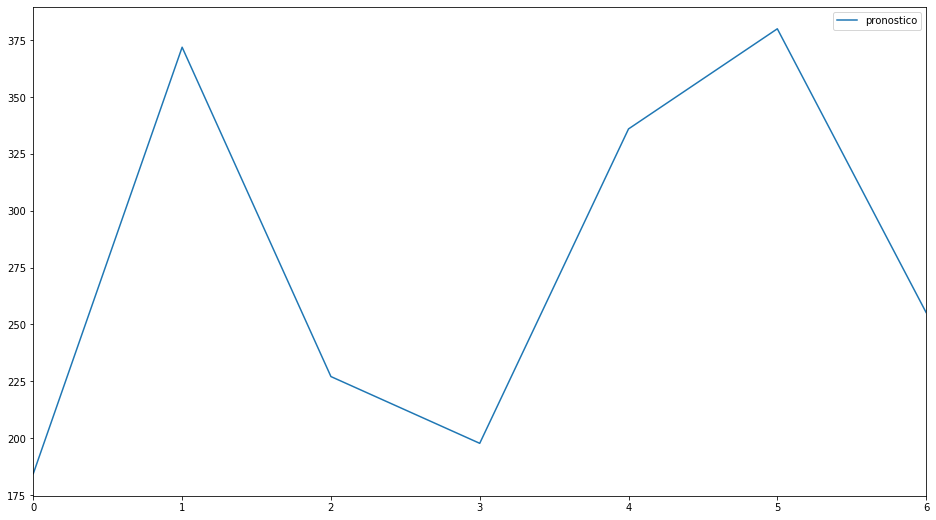

In [27]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico.csv')